## **RNN**

### Objective Statement:

The objective is to develop a time series forecasting model that accurately predicts the monthly milk production for the upcoming months. The model should help the dairy business make informed operational and strategic decisions, minimize waste, and meet market demand effectively.

### **✅ Assignment Tasks**

### 1.	Exploratory Data Analysis (EDA)

o	Visualize trends, seasonality, and anomalies in the milk production data.

o	Check for any missing values or outliers.

o	Normalize or scale the data for neural network models.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

In [30]:
df=pd.read_csv('monthly_milk_production.csv')

In [31]:
df.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [32]:
df.shape

(168, 2)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [34]:
df.describe()

,Production
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


In [35]:
df.isnull().sum()

,0
Date,0
Production,0


In [36]:
df.duplicated().sum()

np.int64(0)

In [37]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


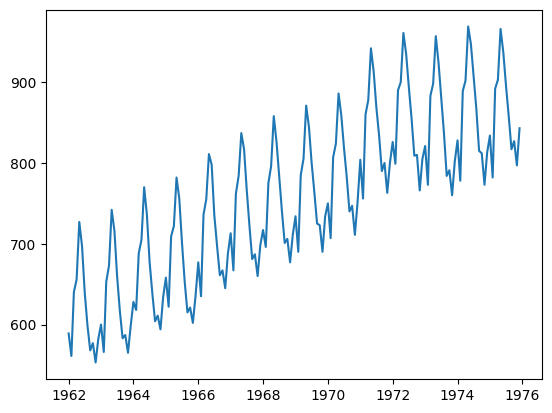

In [38]:
plt.plot(df)
plt.show()

In [39]:
result=seasonal_decompose(df['Production'],model='multiplicative')

Text(0, 0.5, 'Production')

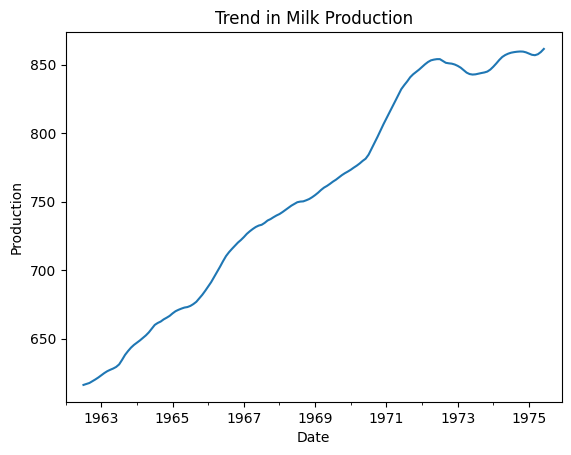

In [40]:
result.trend.plot()
plt.title('Trend in Milk Production')
plt.xlabel('Date')
plt.ylabel('Production')

Text(0, 0.5, 'Production')

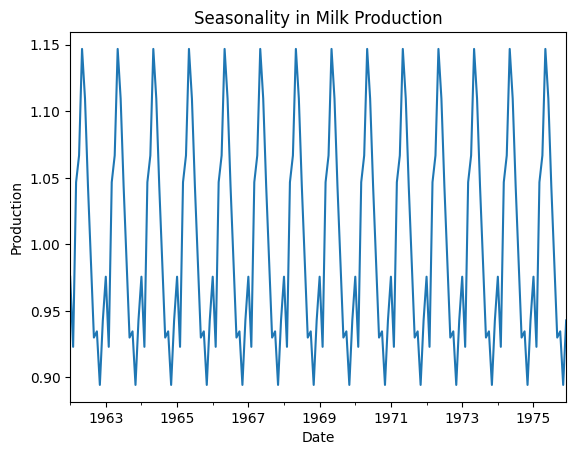

In [41]:
result.seasonal.plot()
plt.title('Seasonality in Milk Production')
plt.xlabel('Date')
plt.ylabel('Production')

Text(0, 0.5, 'Production')

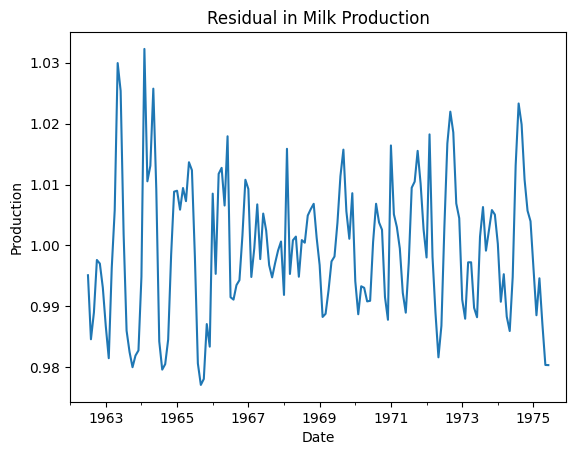

In [42]:
result.resid.plot()
plt.title('Residual in Milk Production')
plt.xlabel('Date')
plt.ylabel('Production')

In [43]:
min_max_sca=MinMaxScaler()
df_scaled = min_max_sca.fit_transform(df[['Production']])

### 2.	Data Preparation for Deep Learning

o	Create input-output sequences (time windows) suitable for training RNNs/LSTMs/GRUs.

o	Split data into training, validation, and test sets.

o	Reshape data for model input dimensions.

In [46]:
# Function to create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [48]:
window_size = 12
X, y = create_sequences(df_scaled, window_size)

In [49]:
split1 = int(len(X) * 0.7)
split2 = int(len(X) * 0.85)

In [50]:
X_train, y_train = X[:split1], y[:split1]
X_val, y_val = X[split1:split2], y[split1:split2]
X_test, y_test = X[split2:], y[split2:]
print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (109, 12, 1), Val shape: (23, 12, 1), Test shape: (24, 12, 1)


In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [52]:
def build_model(model_type='LSTM', window_size=12, units=64, lr=0.001):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(units, input_shape=(window_size, 1)))
    elif model_type == 'LSTM':
        model.add(LSTM(units, input_shape=(window_size, 1)))
    elif model_type == 'GRU':
        model.add(GRU(units, input_shape=(window_size, 1)))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    return model

In [53]:
rnn_model = build_model('RNN', window_size)

In [54]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [55]:
rnn_model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=50, batch_size=16, verbose=1, callbacks=[es])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.2370 - val_loss: 0.0405
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0493 - val_loss: 0.1226
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0244 - val_loss: 0.0146
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0113 - val_loss: 0.0106
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0086 - val_loss: 0.0302
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0051 - val_loss: 0.0075
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040 - val_loss: 0.0077
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0035 - val_loss: 0.0093
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0035 - val_loss: 0.0061
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0032 - val_loss: 0.0054
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0030 - val_loss: 0.0045
E

In [57]:
# Predict
y_pred_rnn_scaled = rnn_model.predict(X_test)
y_test_inv = min_max_sca.inverse_transform(y_test)
y_pred_rnn_inv = min_max_sca.inverse_transform(y_pred_rnn_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


In [58]:
rmse_rnn = np.sqrt(mean_squared_error(y_test_inv, y_pred_rnn_inv))
mae_rnn= mean_absolute_error(y_test_inv, y_pred_rnn_inv)
mape_rnn= np.mean(np.abs((y_test_inv - y_pred_rnn_inv) / y_test_inv)) * 100

In [59]:
print(f"RNN -> RMSE: {rmse_rnn:.2f}, MAE: {mae_rnn:.2f}, MAPE: {mape_rnn:.2f}%")

RNN -> RMSE: 15.02, MAE: 12.42, MAPE: 1.41%


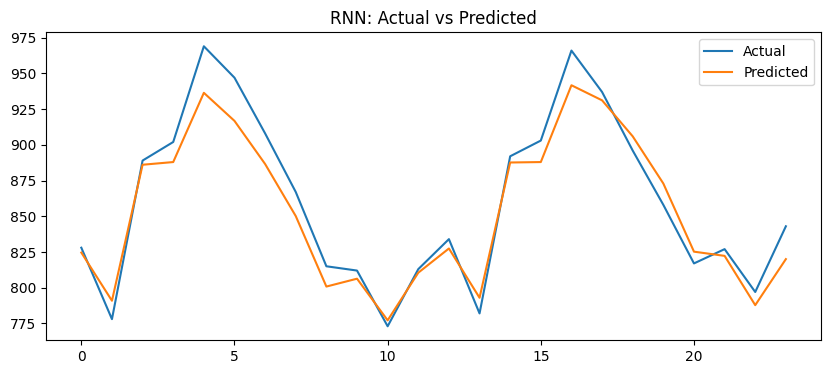

In [60]:
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_rnn_inv, label='Predicted')
plt.title(f'RNN: Actual vs Predicted')
plt.legend()
plt.show()

In [61]:
### LSTM

In [62]:
lstm_model = build_model('LSTM', window_size)

In [63]:
lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val),
               epochs=50, batch_size=16, verbose=1, callbacks=[es])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.2217 - val_loss: 0.3009
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1046 - val_loss: 0.0530
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0280 - val_loss: 0.0381
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0329 - val_loss: 0.0333
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0256 - val_loss: 0.0489
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0311 - val_loss: 0.0356
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0261 - val_loss: 0.0277
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0268 - val_loss: 0.0287
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0266 - val_loss: 0.0284
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0253 - val_loss: 0.0306
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0244 - val_loss: 0.0276
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0258 - val_loss: 0.0254
E

In [64]:
y_pred_lstm_scaled = lstm_model.predict(X_test)
y_pred_lstm_inv = min_max_sca.inverse_transform(y_pred_lstm_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


In [65]:
rmse_lstm= np.sqrt(mean_squared_error(y_test_inv, y_pred_lstm_inv))
mae_lstm= mean_absolute_error(y_test_inv, y_pred_lstm_inv)
mape_lstm= np.mean(np.abs((y_test_inv - y_pred_lstm_inv) / y_test_inv)) * 100

In [66]:
print(f"LSTM -> RMSE: {rmse_lstm:.2f}, MAE: {mae_lstm:.2f}, MAPE: {mape_lstm:.2f}%")

LSTM -> RMSE: 25.76, MAE: 20.70, MAPE: 2.43%


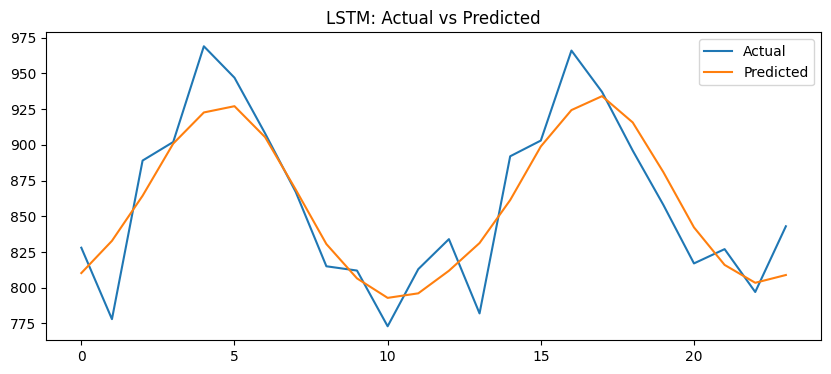

In [67]:
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_lstm_inv, label='Predicted')
plt.title(f'LSTM: Actual vs Predicted')
plt.legend()
plt.show()

In [68]:
gru_model = build_model('GRU', window_size)

In [69]:
gru_model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=50, batch_size=16, verbose=1, callbacks=[es])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.1693 - val_loss: 0.2096
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0444 - val_loss: 0.0411
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0262 - val_loss: 0.0250
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0340 - val_loss: 0.0254
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0230 - val_loss: 0.0410
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0229 - val_loss: 0.0464
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0249 - val_loss: 0.0365
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0196 - val_loss: 0.0275
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0213 - val_loss: 0.0269
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0172 - val_loss: 0.0276
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0193 - val_loss: 0.0281
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0209 - val_loss: 0.0275
E

In [71]:
y_pred_gru_scaled = gru_model.predict(X_test)
y_pred_gru_inv = min_max_sca.inverse_transform(y_pred_gru_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [72]:
rmse_gru= np.sqrt(mean_squared_error(y_test_inv, y_pred_gru_inv))
mae_gru= mean_absolute_error(y_test_inv, y_pred_gru_inv)
mape_gru= np.mean(np.abs((y_test_inv - y_pred_gru_inv) / y_test_inv)) * 100

In [73]:
print(f"GRU -> RMSE: {rmse_gru:.2f}, MAE: {mae_gru:.2f}, MAPE: {mape_gru:.2f}%")

GRU -> RMSE: 62.22, MAE: 54.50, MAPE: 6.34%


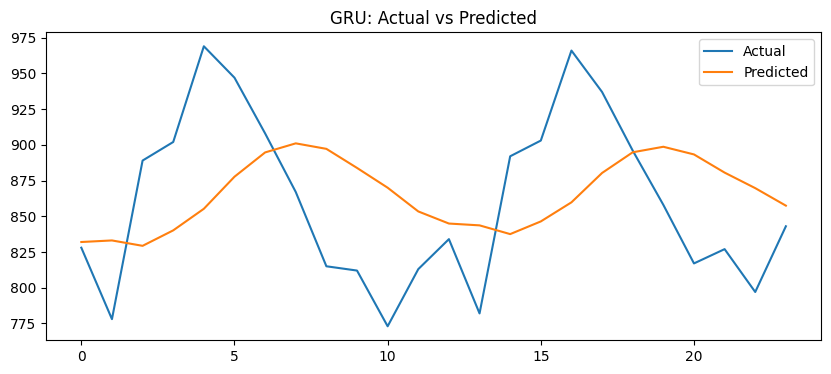

In [74]:
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_gru_inv, label='Predicted')
plt.title(f'GRU: Actual vs Predicted')
plt.legend()
plt.show()

In [75]:
results = {
    'RNN': {'rmse': rmse_rnn, 'mae': mae_rnn, 'mape': mape_rnn},
    'LSTM': {'rmse': rmse_lstm, 'mae': mae_lstm, 'mape': mape_lstm},
    'GRU': {'rmse': rmse_gru, 'mae': mae_gru, 'mape': mape_gru}
}

In [76]:
comp_df = pd.DataFrame({m: {"RMSE": r['rmse'], "MAE": r['mae'], "MAPE": r['mape']}
                        for m, r in results.items()}).T

In [77]:
print('\nModel Comparison:')
print(comp_df)


Model Comparison:
           RMSE        MAE      MAPE
RNN   15.024319  12.415779  1.412152
LSTM  25.762644  20.704475  2.429479
GRU   62.217833  54.495384  6.340500


In [78]:
best_model_name = min(results, key=lambda x: results[x]['rmse'])
print(f"\nBest model: {best_model_name}")


Best model: RNN


In [79]:
def forecast_future(model, last_window, n_steps, scaler):
    """
    Forecast future n_steps using last_window of size 'window_size'.
    model: trained RNN/LSTM/GRU model
    last_window: last observed data (scaled)
    n_steps: number of future months to predict
    scaler: scaler used to scale/normalize the data
    """
    window = last_window.copy()
    preds = []

    for _ in range(n_steps):
        # reshape to (1, window_size, 1) for RNN/LSTM/GRU
        p_scaled = model.predict(window.reshape(1, window.shape[0], 1))
        p = scaler.inverse_transform(p_scaled)[0, 0]  # inverse scale
        preds.append(p)
        window = np.append(window[1:], p_scaled)  # slide window

    return preds

In [81]:
best_model=rnn_model
last_window = df_scaled[-12:]  # last 12 months
future_preds = forecast_future(best_model, last_window, n_steps=12, scaler=min_max_sca)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [82]:
print("Forecasted milk production for next 12 months:")
for i, val in enumerate(future_preds, 1):
    print(f"Month {i}: {val:.2f}")

Forecasted milk production for next 12 months:
Month 1: 833.09
Month 2: 799.39
Month 3: 888.87
Month 4: 888.86
Month 5: 941.15
Month 6: 923.81
Month 7: 895.22
Month 8: 865.22
Month 9: 829.20
Month 10: 836.48
Month 11: 809.07
Month 12: 845.12


In [83]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

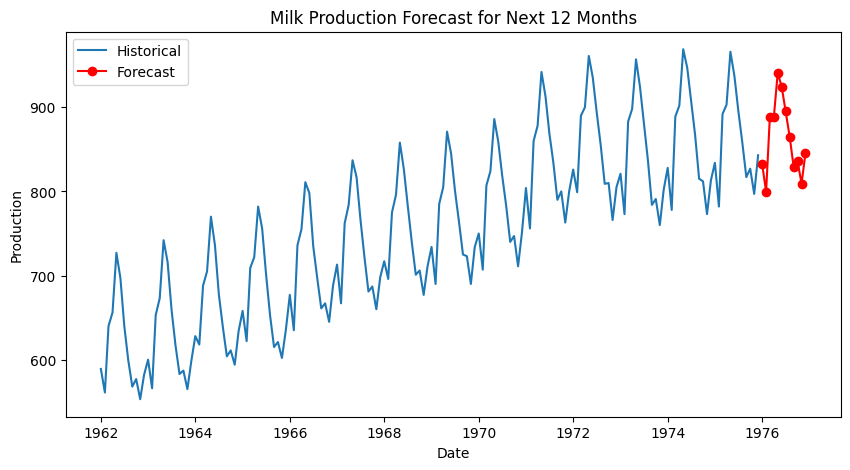

In [84]:
plt.figure(figsize=(10,5))
plt.plot(df.index, df['Production'], label='Historical')
plt.plot(future_dates, future_preds, label='Forecast', color='red', marker='o')
plt.title("Milk Production Forecast for Next 12 Months")
plt.xlabel("Date")
plt.ylabel("Production")
plt.legend()
plt.show()

### Business Insights
Production is relatively stable with slight fluctuations, ranging roughly between 808 – 935 units per month.

Peak months are likely around Month 5 (935.44) and Month 6 (920.57), suggesting higher supply during these months.

Low-production months are Month 11 (808.41) and Month 2 (804.81), indicating periods of lower milk availability.

The fluctuations are predictable, which helps the business plan inventory, staffing, and distribution efficiently.

### Recommendations for the Dairy Business
Increase storage capacity during peak production months and maintain reserves for low-production months.

Schedule deliveries and distribution according to forecasted production to minimize transport costs and meet demand.

Allocate extra staff for processing and packaging during high-production periods and plan maintenance during low-production months.

Adjust feed, veterinary care, and operational resources based on expected production levels to avoid over- or under-allocation.

Use the forecast to plan strategic investments, explore new market opportunities, and optimize overall operations efficiently.